In [1]:
# Dataset가져오는 법
# Competition이 있으면 해당 Competition으로 들어간 뒤 Code에서 New Notebook클릭. 
# 이 실습에서는 https://www.kaggle.com/competitions/dogs-vs-cats-redux-kernels-edition/code
# 해당 Notebook에서 코드 실습할 수 있고, dataset도 이미 들어가 있음. 

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels.h5
/kaggle/input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
/kaggle/input/resnet50/imagenet_class_index.json
/kaggle/input/resnet-50/tensorflow2/classification/1/saved_model.pb
/kaggle/input/resnet-50/tensorflow2/classification/1/variables/variables.index
/kaggle/input/resnet-50/tensorflow2/classification/1/variables/variables.data-00000-of-00001
/kaggle/input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv
/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip
/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip


In [2]:
# 각각의 개, 고양이 이미지 input에 대해 예측하는 모델실습이다. (1 = dog, 0 = cat)
# image size는 224, class는 cat, dog 두 가지이다. 
# training set의 50%만 학습에 사용하고 나머지 50%는 validation에 쓴다. 
# pre-trained model인 ResNet-50을 사용할 것이다. 
# epochs은 10으로 돌린다. 



import os, cv2, random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
from random import shuffle 
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
%matplotlib inline 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
TEST_SIZE = 0.5
RANDOM_STATE = 2018
BATCH_SIZE = 64
NO_EPOCHS = 20
NUM_CLASSES = 2
SAMPLE_SIZE = 20000
PATH = '/kaggle/input/dogs-vs-cats-redux-kernels-edition/'
TRAIN_FOLDER = './train/'
TEST_FOLDER =  './test/'
IMG_SIZE = 224
RESNET_WEIGHTS_PATH = '/kaggle/input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [4]:
train_image_path = os.path.join(PATH, "train.zip")
test_image_path = os.path.join(PATH, "test.zip")

In [5]:
import zipfile
with zipfile.ZipFile(train_image_path,"r") as z:
    z.extractall(".")

In [6]:
with zipfile.ZipFile(test_image_path,"r") as z:
    z.extractall(".")


In [7]:
train_image_list = os.listdir("./train/")[0:SAMPLE_SIZE]
test_image_list = os.listdir("./test/")

print(train_image_list[:10])

['cat.9333.jpg', 'cat.8812.jpg', 'cat.1015.jpg', 'cat.11631.jpg', 'cat.2775.jpg', 'cat.11340.jpg', 'cat.11528.jpg', 'dog.7898.jpg', 'cat.2231.jpg', 'cat.4943.jpg']


In [8]:
# 이미지 파일 이름 첫 3글자를 이용해서 cat이미지인지, dog이미지인지 확인하고 이를 one hot encoding해준다. 
# 고양이 : [1,0], 개 : [0,1].
def label_pet_image_one_hot_encoder(img):
    pet = img.split('.')[-3]
    if pet == 'cat': return [1,0]
    elif pet == 'dog': return [0,1]

In [9]:
def process_data(data_image_list, DATA_FOLDER, isTrain=True):
    data_df = []
    for img in tqdm(data_image_list):
        path = os.path.join(DATA_FOLDER, img)
        if(isTrain):
            label = label_pet_image_one_hot_encoder(img)
        else:
            label = img.split('.')[0]
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) #224 x 224 resizing
        data_df.append([np.array(img), np.array(label)])
    shuffle(data_df)
    return data_df
            

In [10]:
# data 분포 확인 
def plot_image_list_count(data_image_list):
    labels = []
    for img in data_image_list:
        labels.append(img.split('.')[-3])
    print(labels[:20])
    sns.displot(data = labels)
    plt.title('Cats and Dogs')
    
#plot_image_list_count(train_image_list)

In [11]:
#plot_image_list_count(os.listdir(TRAIN_FOLDER))

In [12]:
train = process_data(train_image_list, TRAIN_FOLDER)

100%|██████████| 20000/20000 [00:50<00:00, 393.35it/s]


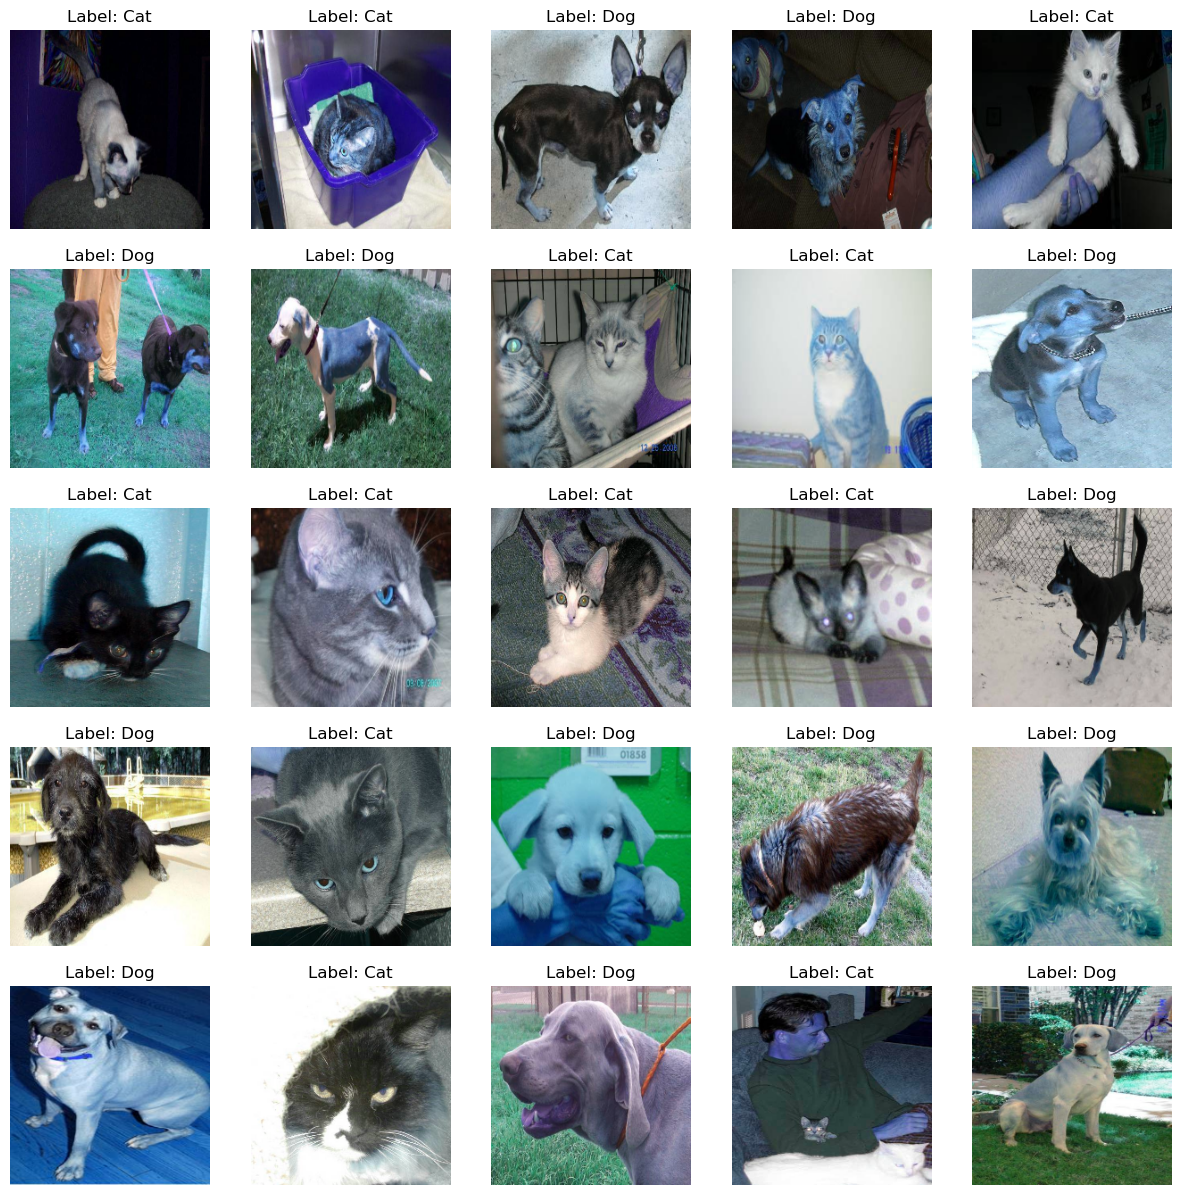

In [13]:
def show_images(data, isTest=False):
    f, ax = plt.subplots(5, 5, figsize=(15, 15))
    for i, data in enumerate(data[:25]):
        img_num = data[1] # one hot encode value
        img_data = data[0] # image data
        label = np.argmax(img_num) # index of largest value
        if label == 1:
            str_label = 'Dog'
        elif label == 0:
            str_label = 'Cat'
        if(isTest):
            str_label = "None"
        ax[i//5, i%5].imshow(img_data)
        ax[i//5, i%5].axis('off')
        ax[i//5, i%5].set_title("Label: {}".format(str_label))
    plt.show()

    

        
show_images(train)

In [14]:
test = process_data(test_image_list, TEST_FOLDER, False)

100%|██████████| 12500/12500 [00:31<00:00, 395.09it/s]


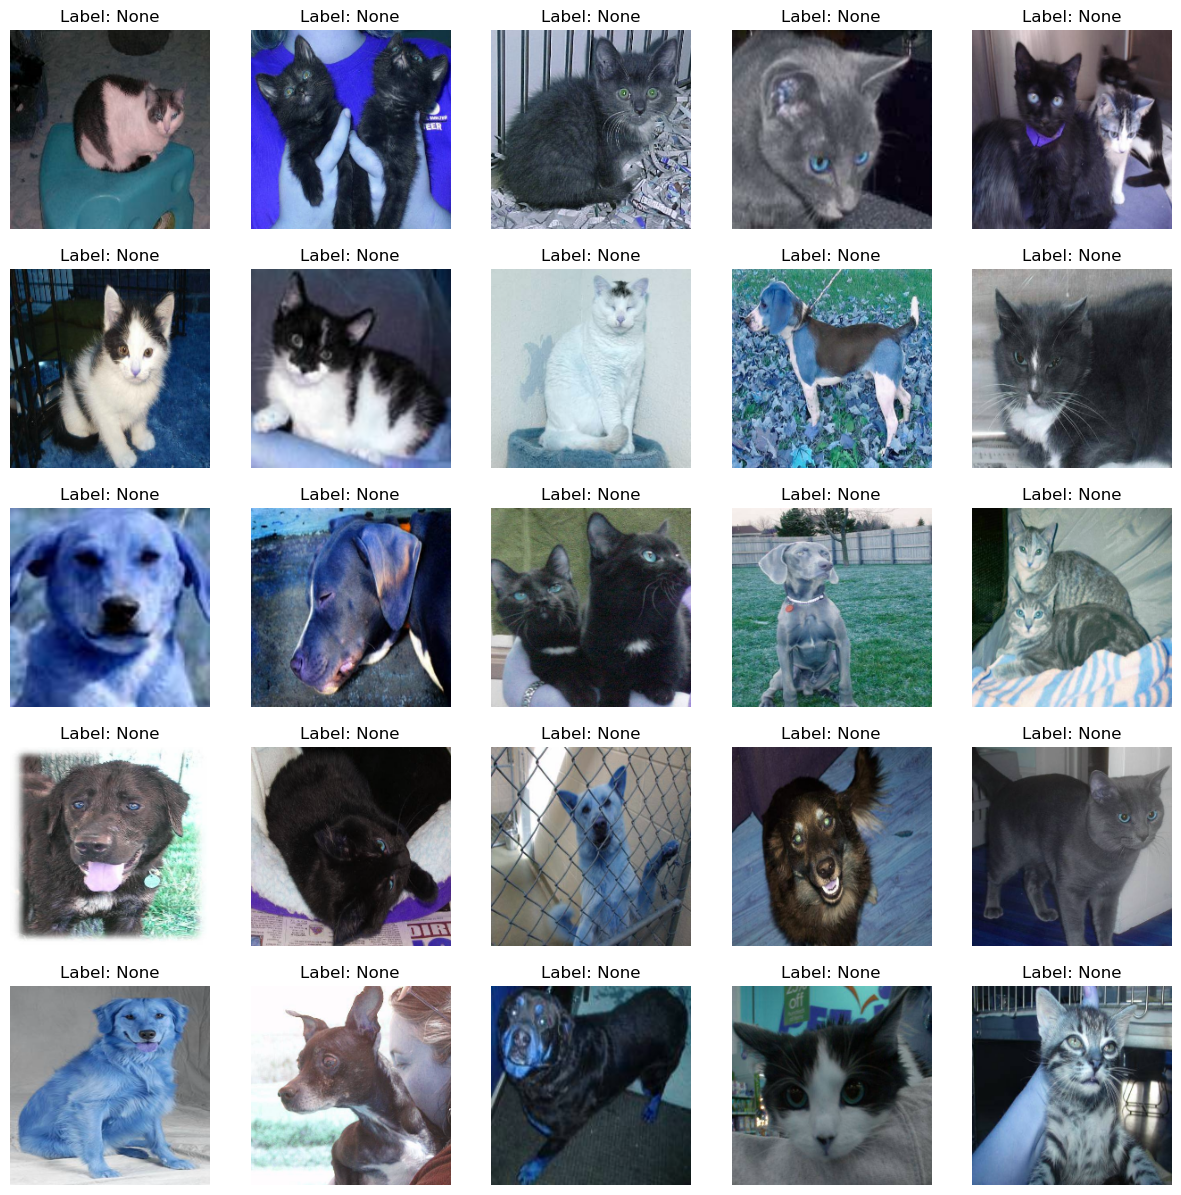

In [15]:
show_images(test, True)

In [16]:
# 학습에 사용할 data를 준비한다. 
# x = image, y = label
x = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
y = np.array([i[1] for i in train])

In [17]:
# 모델 준비 
# ResNet-50을 사용하며 마지막 layer는 softmax 활성 함수를 갖는 Dense layer(FC layer)를 추가해줬다. 
# 첫 layer는 ResNet-50이 이미 학습되어 있으므로 학습하지 않도록 설정한다. 
# ResNet을 사용할 때 add data를 통해 pre-trained된 model을 추가해줘야 한다.(https://www.kaggle.com/datasets/keras/resnet50)

model = Sequential()
# weights를 줄때 풀이대로 하면 안되고 imagenet을 줘서 알아서 git에서 weights를 받아오게 해야 한다. 
# 이때 git에서 받아올 수 있도록 kaggle의 인터넷 연결 설정을 해줘야 한다. 
model.add(ResNet50(include_top=False, pooling='max', weights='imagenet'))
# ResNet-50 모델은 이미 학습되어 있으므로 학습하지 않도록 한다. 
model.layers[0].trainable = True


94765736/94765736 [==============================] - 1s 0us/step


In [18]:
# 모델 컴파일 
# 활성함수는 sigmoid, loss function은 crossentropy로 모델을 컴파일 한다. 

model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
# Model train and summary
# 우선 train data와 validation data를 분리해야 한다. 
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [20]:
train_model = model.fit(x_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=(x_val, y_val))

Epoch 1/20


ValueError: in user code:


    ValueError: Shapes (None, 2) and (None, 2048) are incompatible
